In [15]:
import os
import json
import random
from pathlib import Path
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision import datasets, models
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm


c:\Users\Samri\anaconda3\envs\dlproject\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# ==============================================================================
# Configuration Constants
# ==============================================================================

# --- Dataset Paths ---
DATASET_PATH = "../TestDataSet"  # Path to ImageFolder-structured dataset
LABEL_JSON_PATH = os.path.join(DATASET_PATH, "labels_list.json")  # JSON mapping folder index to ImageNet labels
ADV_DATASET_PATH = "../Adversarial_Test_Set_3"  # Directory to save PGD adversarial examples

# --- Model & Device Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
WEIGHTS = 'IMAGENET1K_V1'  # Pretrained weights identifier

# --- PGD Attack Parameters ---
EPSILON = 0.4          # Maximum L-infinity perturbation (in [0, 1] pixel scale)
PATCH_SIZE = 32        # Patch size (used for visualization or indexing)
PGD_ALPHA = 0.12       # Step size per PGD iteration
PGD_ITERS = 40         # Number of PGD steps

# --- Dataloader Settings ---
BATCH_SIZE = 32        # Batch size for dataloader
NUM_WORKERS = 0        # Dataloader workers (set >0 if system supports)


In [18]:
resnet34 = models.resnet34(weights=WEIGHTS)
resnet34 = resnet34.to(DEVICE)
resnet34.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
MEAN_NORMS = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1).to(DEVICE)
STD_NORMS = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1).to(DEVICE)

In [19]:
# Define normalization and its inverse using ImageNet statistics
normalize = T.Normalize(
    mean=MEAN_NORMS.squeeze().tolist(),
    std=STD_NORMS.squeeze().tolist()
)

inv_normalize = T.Normalize(
    mean=(-MEAN_NORMS / STD_NORMS).squeeze().tolist(),
    std=(1.0 / STD_NORMS).squeeze().tolist()
)


In [20]:
# Define transformation
transform = T.Compose([
    T.ToTensor(),
    normalize
])

label_json_path = os.path.join(DATASET_PATH, "labels_list.json")
with open(label_json_path, "r") as file:
    label_lines = json.load(file)

true_imagenet_indices = [int(entry.split(":")[0]) for entry in label_lines]


In [21]:
# Load dataset with ImageFolder and apply transform
imagefolder = datasets.ImageFolder(root=DATASET_PATH, transform=transform)

# Map folder names to corresponding ImageNet indices
folder_to_imagenet_index = {
    class_name: true_imagenet_indices[idx]
    for idx, class_name in enumerate(imagefolder.classes)
}

# Overwrite sample targets with corresponding ImageNet indices
imagefolder.samples = [
    (img_path, folder_to_imagenet_index[os.path.basename(os.path.dirname(img_path))])
    for img_path, _ in imagefolder.samples
]


In [22]:
dataloader = DataLoader(
    dataset=imagefolder,
    batch_size=1,
    shuffle=False
)

In [23]:
class Denormalize(T.Normalize):
    def __init__(self, mean: torch.Tensor, std: torch.Tensor):
        mean = mean.clone().detach().float()
        std = std.clone().detach().float()

        inv_std = 1.0 / (std + 1e-7)
        inv_mean = -mean * inv_std

        super().__init__(mean=inv_mean.tolist(), std=inv_std.tolist())

    def __call__(self, tensor: torch.Tensor) -> torch.Tensor:
        return super().__call__(tensor.clone())

# Instantiate the denormalization transform
denorm_transform = Denormalize(MEAN_NORMS, STD_NORMS)

In [24]:
os.makedirs(ADV_DATASET_PATH, exist_ok=True)

In [25]:
def apply_pgd_patch_attack(
    input_image, target_label,
    epsilon=EPSILON,
    patch_dim=PATCH_SIZE,
    step_size=PGD_ALPHA,
    num_steps=PGD_ITERS
):
    # Clone and prepare input image
    input_image = input_image.clone().detach().to(DEVICE)
    original_image = input_image.clone().detach()
    _, _, img_height, img_width = input_image.shape

    # Calculate patch coordinates (centered)
    x_start = (img_width - patch_dim) // 2
    y_start = (img_height - patch_dim) // 2

    # Initialize perturbation tensor with gradients
    adversarial_image = input_image.clone().detach().requires_grad_(True)

    for _ in range(num_steps):
        predictions = resnet34(adversarial_image)
        loss = torch.nn.functional.cross_entropy(predictions, target_label)

        resnet34.zero_grad()
        loss.backward()

        gradients = adversarial_image.grad.data
        patch_gradient = gradients[:, :, y_start:y_start + patch_dim, x_start:x_start + patch_dim].sign()

        # Apply perturbation to the selected patch
        updated_image = adversarial_image.clone()
        updated_image[:, :, y_start:y_start + patch_dim, x_start:x_start + patch_dim] += step_size * patch_gradient

        # Project the perturbed image back into the valid epsilon-ball and image space
        clipped_image = torch.max(torch.min(updated_image, original_image + epsilon), original_image - epsilon)
        adversarial_image = torch.clamp(clipped_image, 0, 1).detach().requires_grad_(True)

    return adversarial_image.detach()


In [26]:
# Generate adversarial images using patch attack and save them

adversarial_examples = []
ground_truth_labels = []
prediction_flips = []

for index, (image, label) in enumerate(tqdm(dataloader, desc="Applying PGD Patch Attack")):
    image, label = image.to(DEVICE), label.to(DEVICE)

    # Get original model prediction
    with torch.no_grad():
        original_prediction = resnet34(image).argmax(dim=1).item()

    # Generate adversarial image
    adv_image = apply_pgd_patch_attack(
        input_image=image.clone(),
        target_label=label,
        epsilon=0.5,
        patch_dim=32,
        step_size=0.1,
        num_steps=20
    )

    # Get prediction on adversarial image
    with torch.no_grad():
        adversarial_prediction = resnet34(adv_image).argmax(dim=1).item()

    # Record data
    adversarial_examples.append(adv_image.squeeze().cpu())
    ground_truth_labels.append(label.item())
    prediction_flips.append(original_prediction != adversarial_prediction)

    # Save adversarial image
    output_path = os.path.join(ADV_DATASET_PATH, f"{index:04d}.png")
    torchvision.utils.save_image(
        inv_normalize(adv_image.squeeze().cpu()).clamp(0, 1),
        output_path
    )


Applying PGD Patch Attack: 100%|██████████| 500/500 [03:50<00:00,  2.17it/s]



🔍 Side-by-Side Comparison: Original vs Adversarial (Prediction Changed)


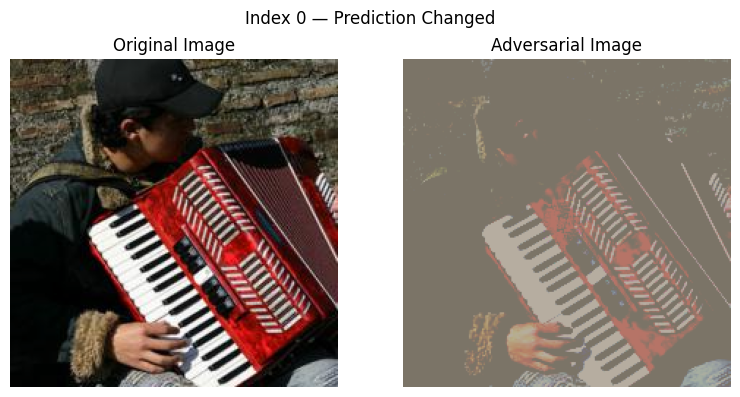

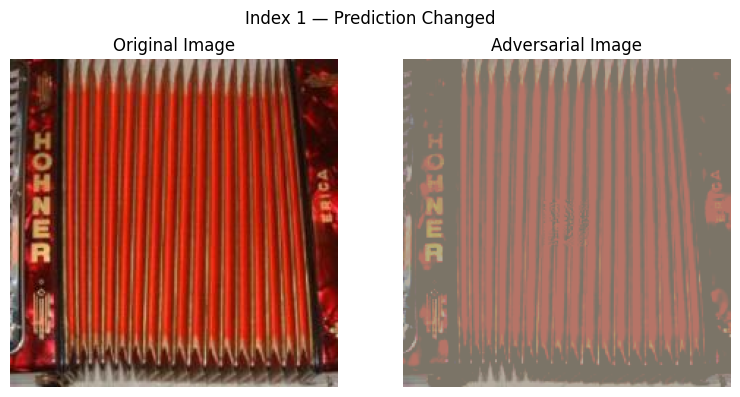

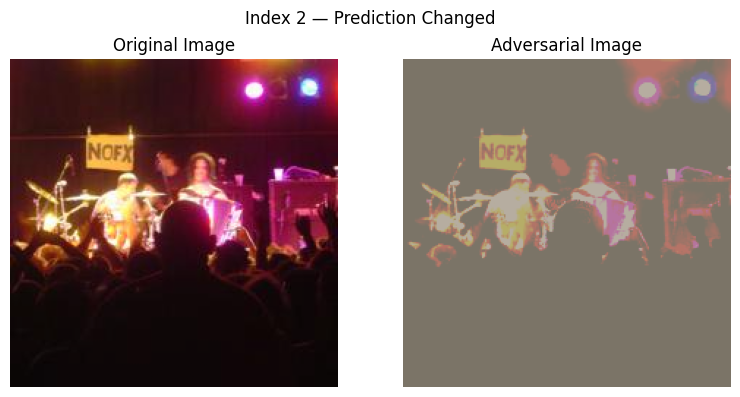

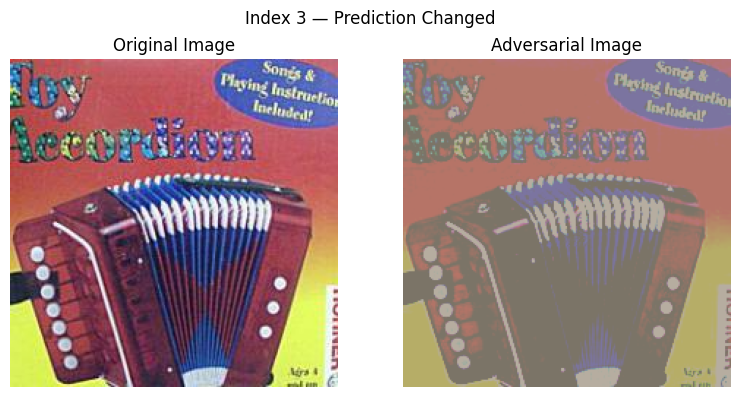

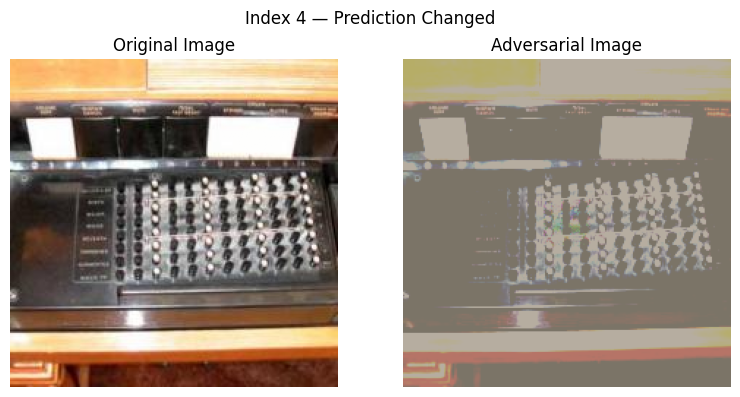

In [ ]:
# ------------------------------------------------------------------------------
# Compare original and adversarial images side-by-side for changed predictions
# ------------------------------------------------------------------------------
print("\n Side-by-Side Comparison: Original vs Adversarial (Prediction Changed)")

visualized = 0
for idx in range(len(adversarial_examples)):
    if prediction_flips[idx]:
        # Load and prepare original image
        orig_img_path = imagefolder.samples[idx][0]
        orig_img = Image.open(orig_img_path).convert("RGB")
        orig_tensor = transform(orig_img).squeeze()

        # Denormalize both images for visualization
        orig_vis = inv_normalize(orig_tensor).clamp(0, 1).permute(1, 2, 0)
        adv_vis = inv_normalize(adversarial_examples[idx]).clamp(0, 1).permute(1, 2, 0)

        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(orig_vis)
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        axes[1].imshow(adv_vis)
        axes[1].set_title("Adversarial Image")
        axes[1].axis("off")

        plt.suptitle(f"Index {idx} — Prediction Changed", fontsize=12)
        plt.tight_layout()
        plt.show()

        visualized += 1
        if visualized == 5:
            break


In [28]:
# Dataset wrapper for adversarial image evaluation
class AdversarialImageDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.image_list = images
        self.label_list = labels

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        return self.image_list[index], self.label_list[index]

# Initialize DataLoader for evaluation
adversarial_dataset = AdversarialImageDataset(adversarial_examples, ground_truth_labels)
adversarial_loader = DataLoader(adversarial_dataset, batch_size=32)


In [ ]:
# Evaluate Top-1 and Top-5 accuracy on a given dataset
def evaluate_model(model, dataloader):
    top1_hits = 0
    top5_hits = 0
    total_samples = 0

    model.eval()
    with torch.no_grad():
        for batch_images, batch_labels in dataloader:
            batch_images = batch_images.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE)

            predictions = model(batch_images)
            _, top1_preds = predictions.topk(1, dim=1)
            _, top5_preds = predictions.topk(5, dim=1)

            top1_hits += (top1_preds.squeeze() == batch_labels).sum().item()
            top5_hits += sum(batch_labels[i] in top5_preds[i] for i in range(batch_labels.size(0)))
            total_samples += batch_labels.size(0)

    top1_acc = 100 * top1_hits / total_samples
    top5_acc = 100 * top5_hits / total_samples
    return top1_acc, top5_acc





Patch Attack Top-1 Accuracy: 11.20%
Patch Attack Top-5 Accuracy: 31.40%


In [30]:
# Evaluate on adversarial images
top1_accuracy, top5_accuracy = evaluate_model(resnet34, adversarial_loader)
print(f"\nPatch Attack Top-1 Accuracy: {top1_accuracy:.2f}%")
print(f"Patch Attack Top-5 Accuracy: {top5_accuracy:.2f}%")


Patch Attack Top-1 Accuracy: 11.20%
Patch Attack Top-5 Accuracy: 31.40%
